#The Erd&#337;s Institute Fall Boot Camp - Team Mahogany

We're using data from [this paper](https://arxiv.org/pdf/2112.02447.pdf) to predict where wildfires spread based on 12 features including wind, temperature, humidity, vegetation, and elevation.

This code does the following:


*   Downloads the data from Google Drive
*   Parses and normalizes the data into training, validation, and test sets.
*   Trains a U-Net shaped convolutional neural network until it stops improving
*   Measures the Precision, Recall, and AUC (PR) on new data
*   Plots the metrics and visualizes predictions



Licensed under the Apache License, Version 2.0
# 1. Imports

Import the required libraries.

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np
import pandas as pd

Note: This links your Google Drive to Colab. Useful if the data is stored in Google Drive.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Common functions

These come from the original paper's [GitHub](https://github.com/google-research/google-research/tree/master/simulation_research/next_day_wildfire_spread), and have been modified slightly.

Run the following three cells to define the required library functions for loading the data.

In [2]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask']

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
# I recalculated the statistics based on the training set only (uncropped)
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    # Elevation
    'elevation' : (0.0, 3536.0, 896.5714, 842.6101),
    # Drought index - this claimed to be pressure, but it's Palmer Drought Severity Index
    # https://en.wikipedia.org/wiki/Palmer_drought_index
    # 0.1 percentile, 99.9 percentile
    'pdsi' : (-6.0559, 6.7432, -0.7729, 2.4407),
    # Normalized Difference Vegetation Index https://gisgeography.com/ndvi-normalized-difference-vegetation-index/
    'NDVI' : (-3826.0, 9282.0, 5350.6865, 2185.2192),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 19.2422, 0.3234289, 1.5336641),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0065263123, 0.003735537), #max changed to 1
    # Wind direction - degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th' : (0.0, 360.0, 146.6468, 3435.0725),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn' : (253.15, 299.6313, 281.85196, 18.4972), #min changed
    # -20 degree C, 99.9 percentile
    'tmmx' : (253.15, 317.3869, 297.71643, 19.4581), #min changed
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs' : (0.0, 9.7368, 3.6278, 1.3092),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc' : (0.0, 109.9254, 53.4690, 25.0980),
    # Population
    # min, 99.9 percentile
    'population' : (0.0, 2935.7548828125, 30.4603, 214.20015),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [3]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

_parse_fn was modified to include sample_weights in addition to the inputs and labels.

This is a mask with 0's where the data is unknown (label: -1 No Data) and 1's where the data is known (label: 0 No Fire or 1: Fire)

This tells the neural network to ignore the missing data when calculating loss functions and training

In [4]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))

# Modified

def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)

  weights = tf.cast(tf.greater_equal(output_img, tf.zeros_like(output_img)), tf.int32)

  return input_img, output_img, weights


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

Depending on the cutoff, we could report ~100% precision or 100% accuracy, trading one off for the other.

This function returns the precision and recall that maximize the F1-score, for consistency.

For certain cutoffs, the precision is undefined, so it is recorded as 0.

In [5]:
def get_metrics(precs, recs):
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
  return precs[np.argmax(f1s)], recs[np.argmax(f1s)]

Define the features in the dataset

In [6]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# 3. Load the dataset

Enter the file pattern of the dataset.

If you are running this notebook locally, and your data is not stored in Google Drive, change the file_pattern below to where your data is stored locally.

In [7]:
file_pattern = 'next_day_wildfire_spread_train*'
#Location within MY GDrive. Might not be the same for you. I don't know if you can link to my drive this way...
val_file_pattern = 'next_day_wildfire_spread_eval*'

test_file_pattern = 'next_day_wildfire_spread_test*'

Get the training, validation, and testing datasets


We randomly crop the training data, so each epoch of the neural network gets a new set of 15,000 fire images to train off of.

We center crop the images for validation and testing.

In [8]:
one_batch = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=32, #We don't go through the whole dataset at once. It takes 468 loops to do the whole thing.
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=14979,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

valset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

testset = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

# 4. UNET-Style Convolutional Neural Network

More imports! Fun!

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

We double the number of filters each layer of the encoder, and halve them for the decoder.
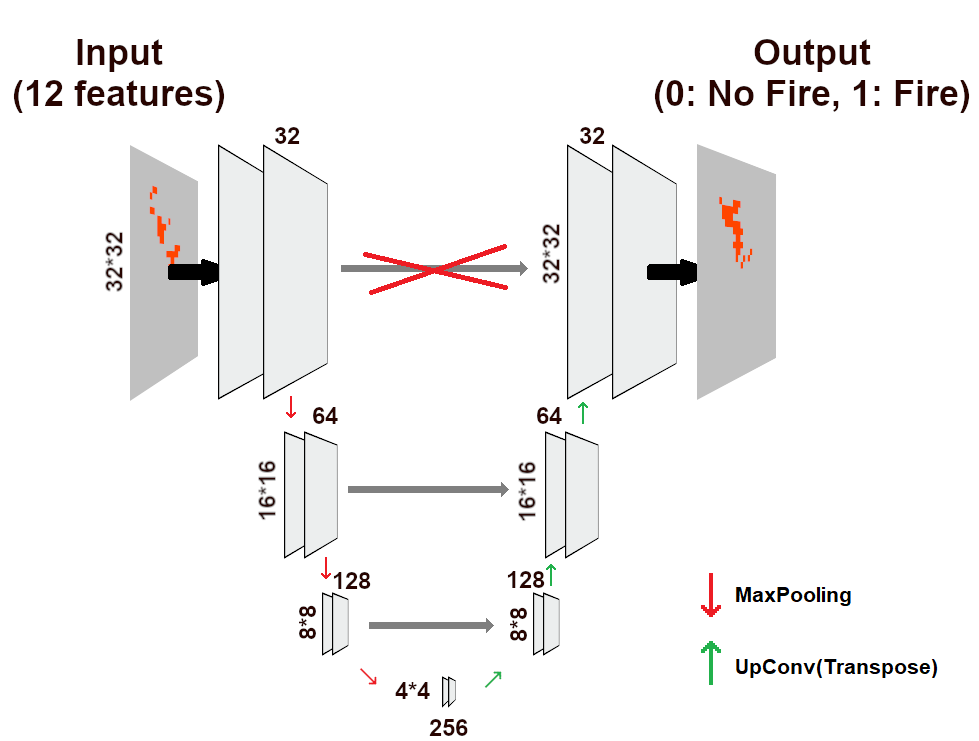

In [10]:
def conv_block(prev_output, filters, kernel):
    x = Conv2D(filters, kernel, padding = "same")(prev_output)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(filters, kernel, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    return LeakyReLU(0.1)(x)

In [11]:
def up_conv_block(prev_output, filters, kernel):
    x = Conv2D(filters, kernel, padding = "same")(prev_output)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(filters//2, kernel, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    return LeakyReLU(0.1)(x)

In [13]:
sample_size = dataset.element_spec[0].shape[1]

# Create UNET style model - This first one is the same as the paper
model_input = keras.Input(shape=(sample_size, sample_size, 12), name="original_img") # input is 32*32

#Downsample
block_1_output = conv_block(model_input, 32, 3)
x = MaxPooling2D(2)(block_1_output) #output is 16 * 16
block_2_output = conv_block(x, 64, 3)
x = MaxPooling2D(2)(block_2_output) #output is 8*8
block_3_output = conv_block(x, 128, 3)
x = MaxPooling2D(2)(block_3_output) #output is 4*4

#bottom layer bottleneck
x = conv_block(x, 256, 3) # still 4x4

#upsample
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(128, 3, strides = 2, padding = "same")(x) # output is 8*8
x = layers.BatchNormalization()(x)
first_up_layer = layers.add([block_3_output, x])
x = up_conv_block(first_up_layer, 256, 3)
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(64, 3, strides = 2, padding = "same")(x) # output is 16*16
x = layers.BatchNormalization()(x)
second_up_layer = layers.add([block_2_output, x])
x = up_conv_block(second_up_layer, 128, 3)
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(32, 3, strides = 2, padding = "same")(x) # output is 32*32
x = layers.BatchNormalization()(x)
# Eliminating the skip connection from the input results in increased performance.
# This is reflected by a red X in the diagram above
# x = layers.add([block_1_output, x]) # Third_up_layer
x = up_conv_block(x, 64, 3)

predictions = Conv2D(1, 3, activation = "sigmoid", padding="same")(x) #Force output to be 0,1

# this is the model we will train
model = Model(inputs=model_input, outputs=predictions)

model.summary() # It's not as deep as Inception, but it'll do



# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC()])
# optimizer changed to adam from rmsprop because it's spoopier

# Save the best model.
checkpoint = ModelCheckpoint('best_default_model.keras', monitor='val_loss', save_best_only=True, save_freq=1)

# stop training if it's overfitting # may need to increase regularization
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
CALLBACKS=[checkpoint,early]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_img (InputLayer) │ (None, 32, 32, 12)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 32, 32, 32)     │          3,488 │ original_img[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 32, 32, 32)     │            128 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_14            │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ leaky_re_lu_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 32, 32, 32)     │            128 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 32)     │              0 │ leaky_re_lu_15[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 16, 16, 64)     │            256 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_16            │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 16, 16, 64)     │         36,928 │ leaky_re_lu_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 16, 16, 64)     │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_17            │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 8, 8, 64)       │              0 │ leaky_re_lu_17[0][0]   │
│ (MaxPooling2D)       

 Total params: 2,344,673 (8.94 MB)

 Trainable params: 2,340,961 (8.93 MB)

 Non-trainable params: 3,712 (14.50 KB)

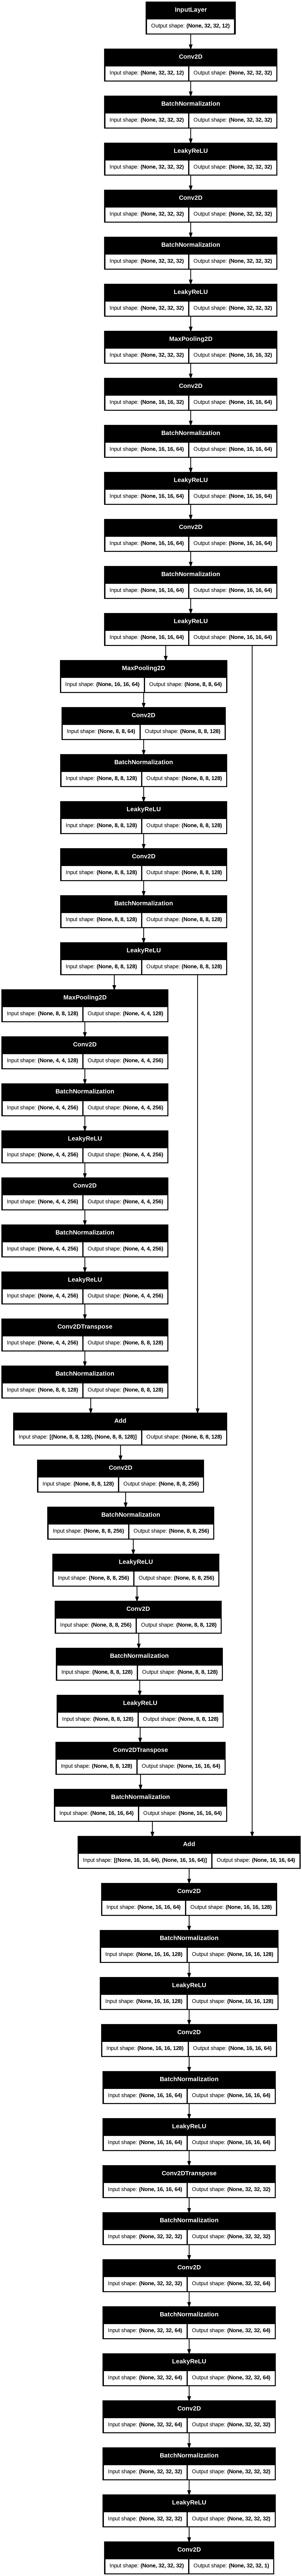

In [15]:
#Uncomment and turn sideways to see the beautiful U-shaped architecture.
keras.utils.plot_model(model, "UNet.png", show_shapes=True)

This randomly crops new 32*32 squares from the data and runs 1 epoch. Then it does it again.

We could have done model.fit with (inputs, labels) representing inputs and outputs to fit, but it would pick the SAME 15,000 inputs and outputs instead of taking advantage of the random cropping.

It shows a lot more data to the model, improving performance

Sometimes this doesn't run. This is a known bug. To fix, restart kernel and run fresh.

Alternatively, you can just use the same 15,000 fires over and over again without random cropping running the code chunk below

In [16]:
# train the model on the new data for a few epochs
print("Model has started training")
EPOCHS = 25


history = model.fit(one_batch, #tf.data.dataset takes full advantage of the data generator above
          epochs = EPOCHS,
          validation_data = valset,
          callbacks = CALLBACKS)

# If the above code doesn't run, get a batch of inputs and labels, then run the below code:
# inputs, labels, weights = next(iter(dataset))
# history = model.fit(inputs, labels,
#                     sample_weight = sample_weight,
#                     epochs = EPOCHS,
#                     batch_size = 64,
#                     validation_data = (inputs_val, labels_val))

Model has started training
Epoch 1/25
      7/Unknown 25s 30ms/step - auc_1: 0.5064 - loss: 0.7229

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:202: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


    469/Unknown 47s 47ms/step - auc_1: 0.5578 - loss: 0.2901

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 101ms/step - auc_1: 0.5580 - loss: 0.2899 - val_auc_1: 0.6593 - val_loss: 0.1377
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - auc_1: 0.6893 - loss: 0.0897 - val_auc_1: 0.6558 - val_loss: 0.1354
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - auc_1: 0.7072 - loss: 0.0863 - val_auc_1: 0.6694 - val_loss: 0.1351
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - auc_1: 0.7037 - loss: 0.0834 - val_auc_1: 0.6980 - val_loss: 0.1328
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - auc_1: 0.7053 - loss: 0.0790 - val_auc_1: 0.6929 - val_loss: 0.1305
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - auc_1: 0.6888 - loss: 0.0758 - val_auc_1: 0.6793 - val_loss: 0.1366
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - auc_1: 0.7005 - loss: 0.0775 - val_auc_1: 0.6537 - val_loss: 0.1323
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - auc_1: 0.6951 - loss: 0.0776 - val_auc_1: 0.6813 - val_loss: 0.1312
Epoch 9/25
469/469

I like to save the model only after I made an archtecture change, or if it's SOTA on the validatoin set.

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Models/UNET_retrained.model')

In [19]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['auc_1', 'loss', 'val_auc_1', 'val_loss'])


Display AUC and losses. This quickly has limiting returns, which is why EarlyStopping is so helpful.

In [20]:
length = len(history_dict['loss'])+1

plt.figure(figsize = (14,6))

plt.scatter(range(1,length), history_dict['auc'], label = "Training AUC")
plt.scatter(range(1,length), history_dict['val_auc'], marker='v', label = "Validation Set AUC")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Area Under Curve (PR)", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()


plt.figure(figsize = (14,6))

plt.scatter(range(1,length), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,length), history_dict['val_loss'], marker='v', label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss Function Value", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

KeyError: 'auc'

<Figure size 1400x600 with 0 Axes>

# 5. Metrics: Precision, Recall, AUC (PR)

This section of code takes the predictions and labels, and returns a bunch of metrics.

In order to run it, you have to specifiy whether you want the metrics for the training data, validation data, or test data.

To start, import the confusion matrix so we can get the actual fires and predicted fires

In [21]:
## now we can import the confusion matrix
from sklearn.metrics import confusion_matrix

TF Datasets are loaded lazily, so materialize the first batch of inputs (11 environmental features) and labels (fire mask).



In [22]:
inputs, labels, weights = next(iter(dataset))

inputs_val, labels_val, _ = next(iter(valset))

inputs_test, labels_test, _ = next(iter(testset))

Reshape the data in the next two cells for predictions and to remove "no data" files

In [23]:
X = inputs
y = tf.reshape(labels, [-1]).numpy() #len(labels)*32*32

y_val = tf.reshape(labels_val, [-1]).numpy()

y_test = tf.reshape(labels_test, [-1]).numpy()

In [24]:
#Leave these commented if you want the training accuracy
#Uncomment one or the other if you want the val/test data
# X, y = inputs_val, y_val
X, y = inputs_test, y_test

#Don't bother learning where no-data is during training.
#makes training quicker and binary (thank fuck)
y_pred = model.predict(X).reshape(-1)
y_pred = y_pred[np.where(y >= 0)]
y = y[np.where(y >= 0)]

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step


Get the actual fire and predicted fire values

In [25]:
## just like mse, actual then prediction
cum = confusion_matrix(y, np.round(y_pred))
cum

array([[1619325,    3607],
       [  55351,    4352]])

Get the True Negative (TN), False Positive (FP), False Negative (FN), and True Positive (TP)



In [26]:
## Calculate the confusion matrix here

TN = cum[0,0]
FP = cum[0,1]
FN = cum[1,0]
TP = cum[1,1]

Get the baseline precision and recall


The baseline precision is with a cutoff of 0.5 (>0.5 means fire and <0.5 means no fire).

This isn't always ideal, as the model regularly predictions regions are on fire with, say 30% confidence.

In [27]:
## calculate recall and precision here
print("The baseline precision is",
         np.round(TP/(FP + TP), 4))

print("The baseline recall is",
         np.round(TP/(FN + TP), 4))

The baseline precision is 0.5468
The baseline recall is 0.0729


So we sweep through all the cutoffs to see which combination of precision/recall is best.

In [28]:
 ## Now plot how the accuracy (sensitivity/specificity) changes with the cutoff
cutoffs = np.arange(0.001,.975,.001)
precs = []
recs = []
y = y.astype(int)

for cutoff in cutoffs:
    TP = (1*(y_pred >= cutoff) & y).sum()
    PP = 1*(y_pred >= cutoff).sum() #predicted positives = # Denominator for precision
    AP = y.sum() #Actual positives # Denominator for recall
    precs.append(TP/PP)
    recs.append(TP/AP)

<ipython-input-28-5bbb3b50798d>:11: RuntimeWarning: invalid value encountered in scalar divide
  precs.append(TP/PP)


In [29]:
prec, rec = get_metrics(precs, recs)

auc = tf.keras.metrics.AUC(curve = 'PR')
auc.update_state(y, y_pred)

print("The best precision is", prec)
print("The best recall is", rec)
print("The auc is", auc.result().numpy())

<ipython-input-5-37b4cf7522e5>:2: RuntimeWarning: invalid value encountered in divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


The best precision is 0.3299347420369002
The best recall is 0.44120060968460545
The auc is 0.28737262


# 6. Plot of Precision/Recall curves

Nothing fancy. Just seeing how they each change as the cutoff changes.

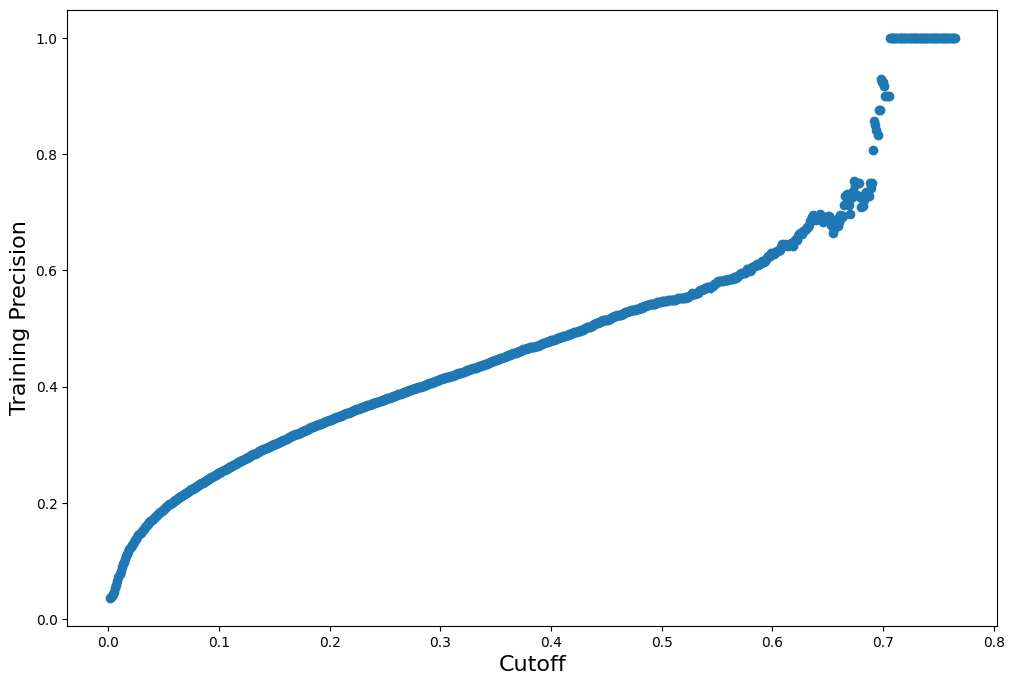

In [30]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,precs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Precision",fontsize=16)

plt.show()

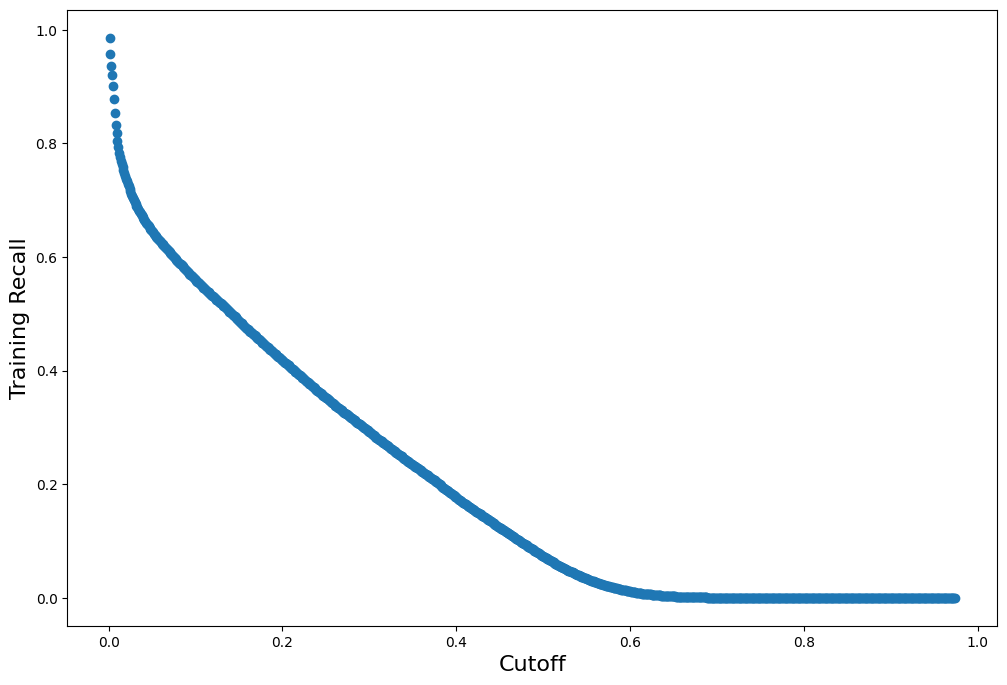

In [31]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,recs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Recall",fontsize=16)

plt.show()

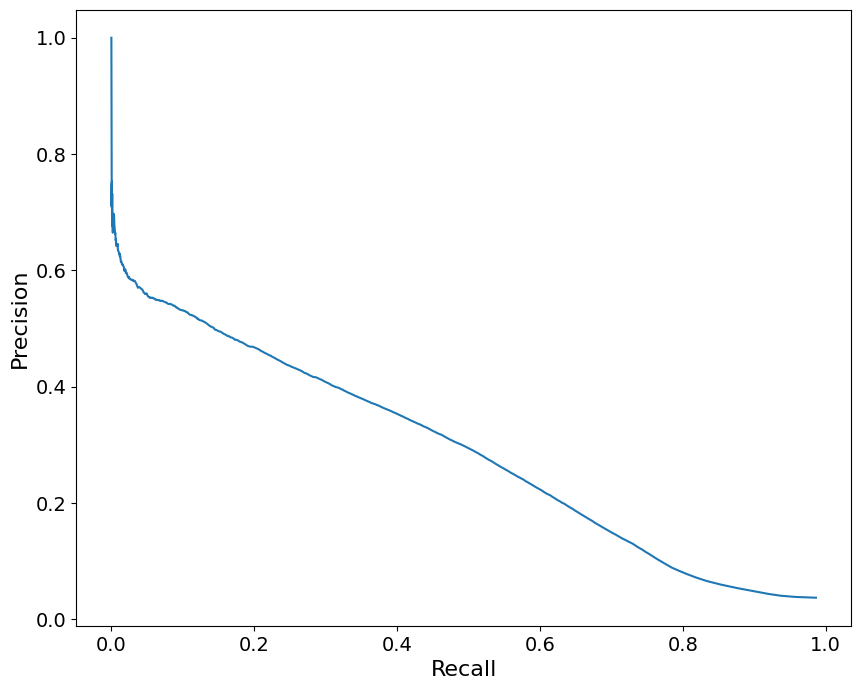

In [32]:
plt.figure(figsize=(10,8))

plt.plot(recs, precs)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Remember, we report precision and recall that maximize the F1-score, which usually involves a relatively low threshold for fire.

<ipython-input-33-6bd9b1a1fe46>:3: RuntimeWarning: invalid value encountered in divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


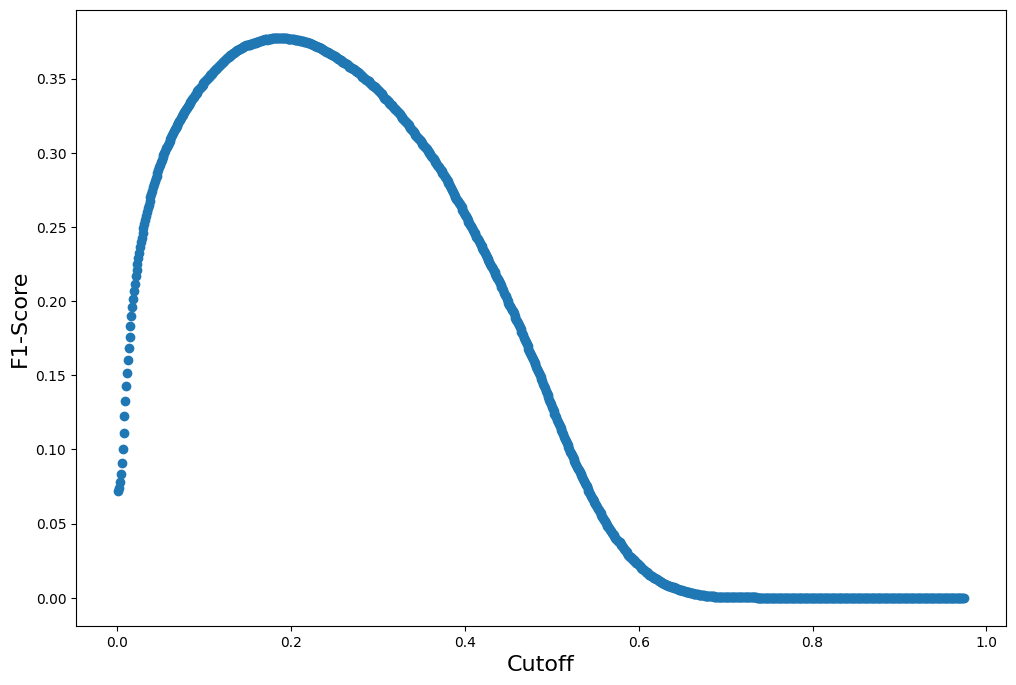

In [33]:
plt.figure(figsize=(12,8))

f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
plt.scatter(cutoffs,f1s)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("F1-Score",fontsize=16)

plt.show()

# 7. Plotting function

Visualize the predicions on a few new inputs

In [34]:
n_rows = 10
n_features = inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


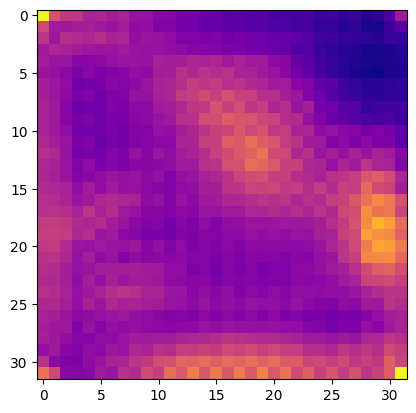

In [35]:
pred = model.predict(inputs_test).reshape((len(inputs_test),32,32))
plt.imshow(pred[0], cmap='plasma')

Plot the Last fire, Actual fire, and Predicted fire for comparison to see how well this model did in predicting fire.

Note that for inputs with no fire (presumably, it was cropped out), it generally predicts there will be no fire (<2% chance).

For all other inputs, it generally predicts a larger bubble around the fire, accounting for wind/terrain.

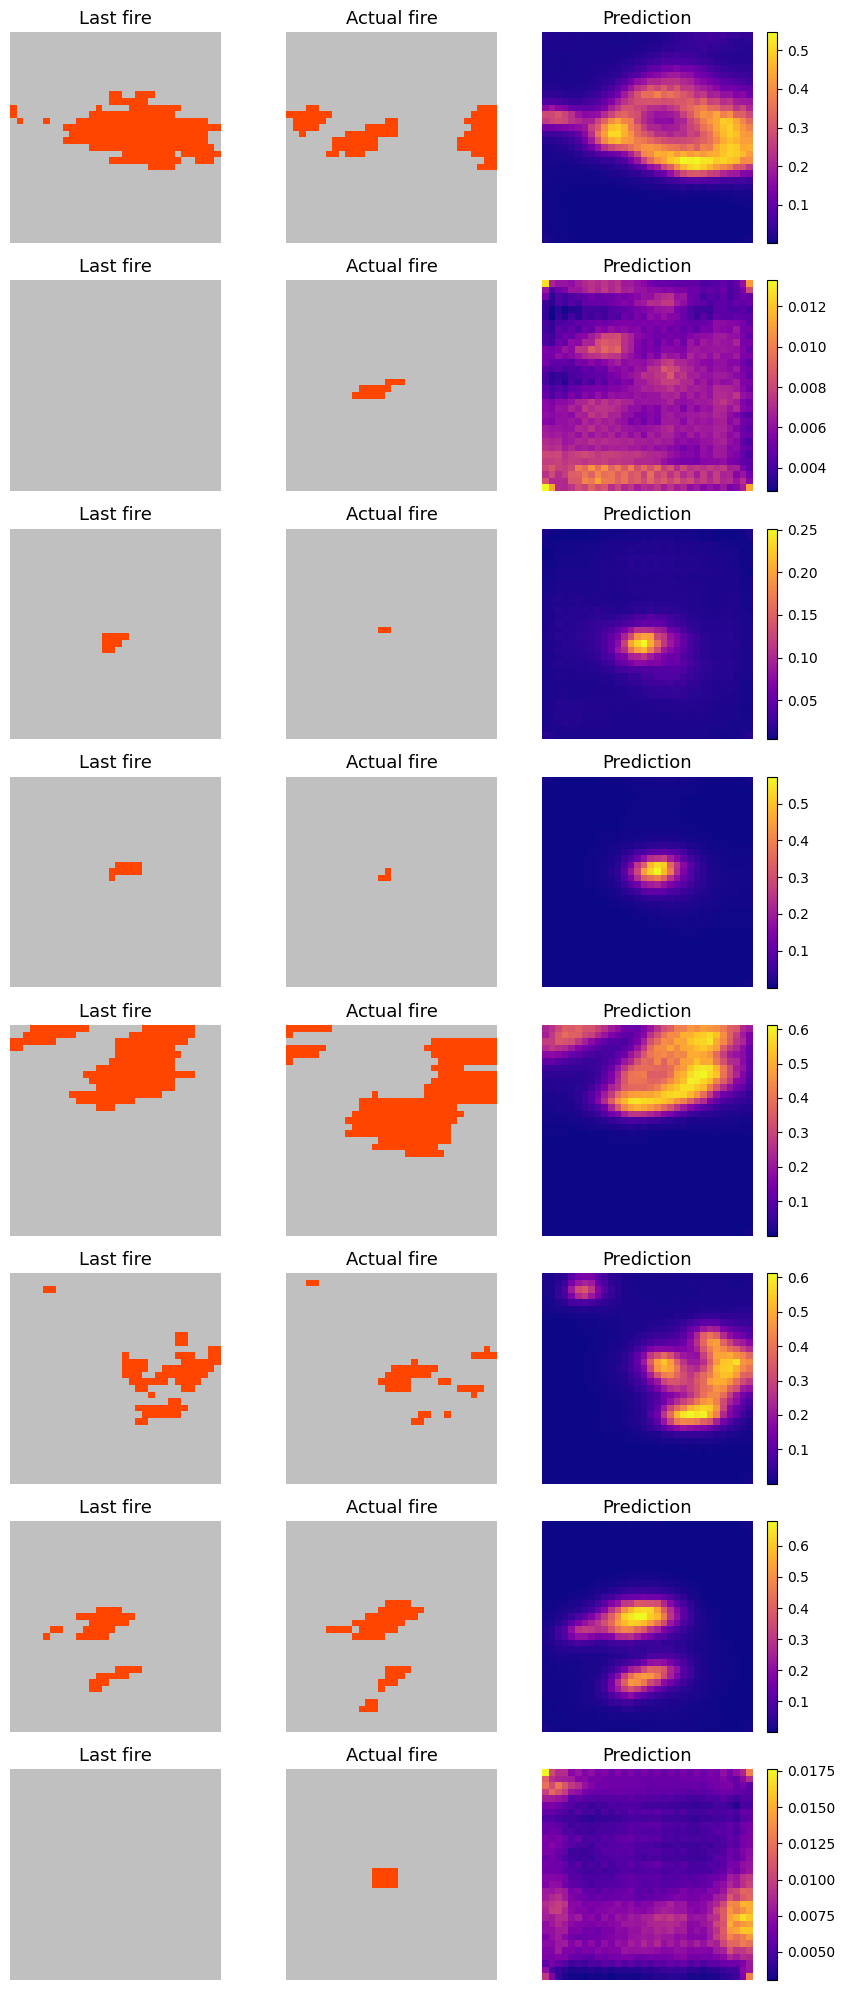

In [36]:
fig = plt.figure(figsize=(9,20))
n_rows = 8

for i in range(n_rows):
  fire_index = i +1000
  plt.subplot(n_rows,3, 3*i + 1)
  plt.title("Last fire", fontsize=13)
  plt.imshow(inputs_test[fire_index, :, :, -1], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 2)
  plt.title("Actual fire", fontsize=13)
  plt.imshow(labels_test[fire_index, :, :, 0], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 3)
  plt.title("Prediction", fontsize=13)
  plt.imshow(pred[fire_index], cmap='plasma')
  plt.colorbar()
  plt.axis('off')
plt.tight_layout()


=== Sample #1000 ===
Total predicted-fire pixels above cutoff 0.5: 10
Pixel (row=15, col=10) => {'elevation': 1.558762, 'th': 0.033744298, 'vs': -0.28659818, 'tmmn': 0.010611826, 'tmmx': 0.076113194, 'sph': -0.303437, 'pr': -0.2108864, 'pdsi': -0.06647101, 'NDVI': 0.04224449, 'population': -0.14220485, 'erc': 0.79118174}
Pixel (row=15, col=11) => {'elevation': 1.6940559, 'th': 0.033399913, 'vs': -0.290572, 'tmmn': 0.015554772, 'tmmx': 0.07846105, 'sph': -0.3019542, 'pr': -0.2108864, 'pdsi': -0.06441402, 'NDVI': -0.8135049, 'population': -0.14220485, 'erc': 0.7967407}
Pixel (row=18, col=28) => {'elevation': 1.1338917, 'th': 0.03334946, 'vs': -0.30612364, 'tmmn': 0.04726981, 'tmmx': 0.11620397, 'sph': -0.28764358, 'pr': -0.2108864, 'pdsi': -0.061617553, 'NDVI': -0.83821636, 'population': -0.14220485, 'erc': 0.81785846}
Pixel (row=19, col=20) => {'elevation': 1.2003518, 'th': 0.03438138, 'vs': -0.29287678, 'tmmn': 0.031211834, 'tmmx': 0.086993, 'sph': -0.2843965, 'pr': -0.2108864, 'pdsi'

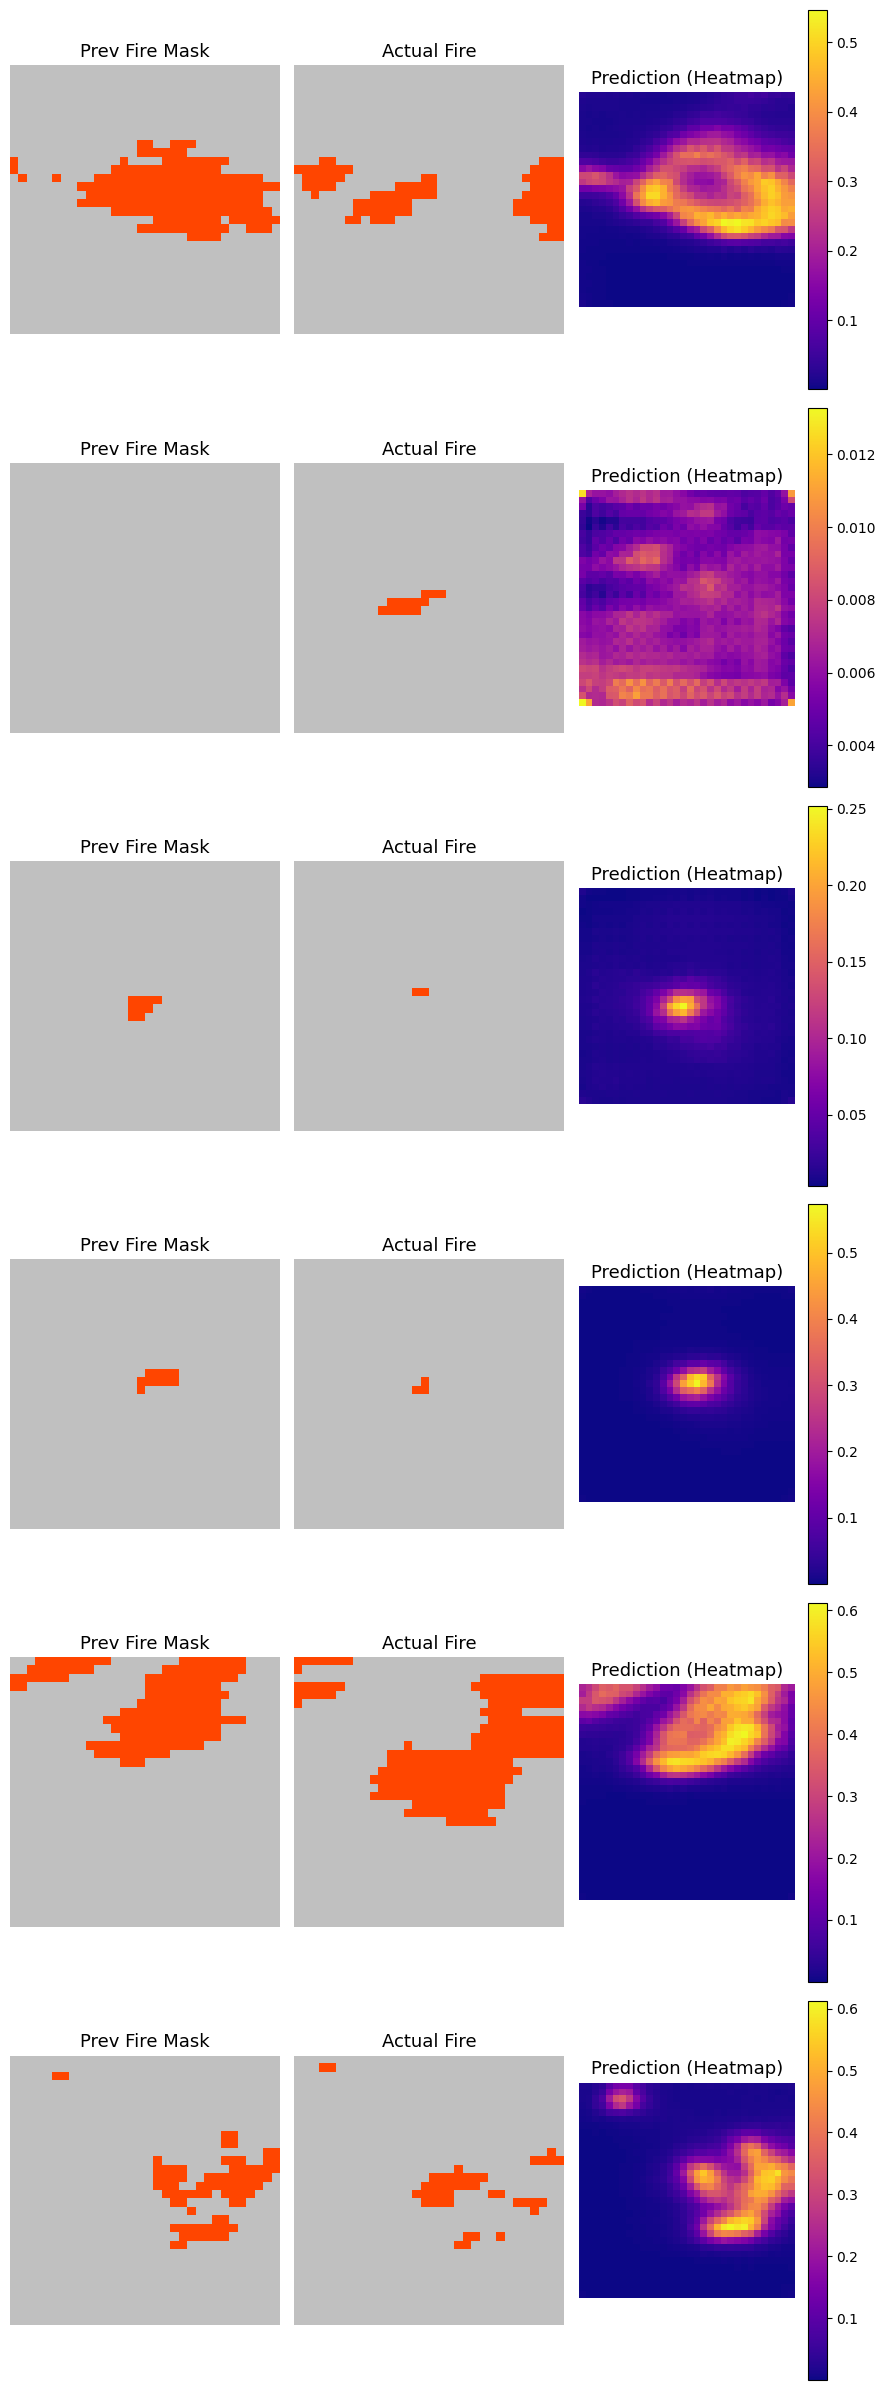

In [37]:
FEATURES_TO_PRINT = [
    'elevation', 'th', 'vs', 'tmmn', 'tmmx', 'sph',
    'pr', 'pdsi', 'NDVI', 'population', 'erc'
]

# If you want them in the exact order of INPUT_FEATURES, ensure your code
# indices them accordingly. For example, if PrevFireMask is the 12th channel,
# then indices 0..10 match the listed features above.

fig = plt.figure(figsize=(9, 24))
n_rows = 6     # how many sets of images to show
threshold = 0.5  # cutoff for "predicted fire"

for i in range(n_rows):
    fire_index = i + 1000  # pick whichever sample indices you like

    # 1) Show the last fire (input channel = -1 if it's indeed the last channel)
    plt.subplot(n_rows, 3, 3*i + 1)
    plt.title("Prev Fire Mask", fontsize=13)
    plt.imshow(inputs_test[fire_index, :, :, -1], cmap=CMAP, norm=NORM)
    plt.axis('off')

    # 2) Actual fire (the label)
    plt.subplot(n_rows, 3, 3*i + 2)
    plt.title("Actual Fire", fontsize=13)
    plt.imshow(labels_test[fire_index, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')

    # 3) Model prediction heatmap
    plt.subplot(n_rows, 3, 3*i + 3)
    plt.title("Prediction (Heatmap)", fontsize=13)
    plt.imshow(pred[fire_index], cmap='plasma')
    plt.colorbar()
    plt.axis('off')

    # ---------------------------
    # PRINT FEATURE VALUES WHERE PREDICTION >= threshold
    # ---------------------------
    pred_mask = pred[fire_index] >= threshold  # boolean mask for predicted fire
    fire_pixels = np.argwhere(pred_mask)        # list of (row, col) for "fire"

    print(f"\n=== Sample #{fire_index} ===")
    print(f"Total predicted-fire pixels above cutoff {threshold}: {len(fire_pixels)}")

    # For each 'fire' pixel, fetch features
    for (row_idx, col_idx) in fire_pixels:
        # features in input: shape = (32, 32, <num_features>)
        # we assume channel i in the input corresponds to FEATURES_TO_PRINT[i].
        pixel_features = inputs_test[fire_index, row_idx, col_idx, :]  # shape (12,)

        # Build a dict { feature_name : value }
        # CAREFUL: The index in pixel_features must match the order in
        #          INPUT_FEATURES you used. If your model input channels
        #          are in exactly the same order as FEATURES_TO_PRINT,
        #          you can do it directly. Otherwise, map them properly.
        feature_dict = {}
        for f_idx, f_name in enumerate(FEATURES_TO_PRINT):
            feature_dict[f_name] = pixel_features[f_idx].numpy()

        # Print out that pixel's row,col plus the features
        print(f"Pixel (row={row_idx}, col={col_idx}) => {feature_dict}")

plt.tight_layout()
plt.show()


=== Sample #1000 ===
Max predicted-fire probability = 0.5468 at (row=19, col=21)
   elevation       = 1.18492
   th              = 0.03431
   vs              = -0.29454
   tmmn            = 0.03364
   tmmx            = 0.09063
   sph             = -0.28414
   pr              = -0.21089
   pdsi            = -0.11178
   NDVI            = 1.66496
   population      = -0.14220
   erc             = 0.80324
   PrevFireMask    = 1.00000

=== Sample #1001 ===
Max predicted-fire probability = 0.0133 at (row=31, col=0)
   elevation       = -1.02844
   th              = 0.01133
   vs              = -1.32861
   tmmn            = -0.36268
   tmmx            = -0.10615
   sph             = 0.10603
   pr              = -0.21089
   pdsi            = -0.07283
   NDVI            = 0.64264
   population      = -0.02705
   erc             = -1.19129
   PrevFireMask    = 0.00000

=== Sample #1002 ===
Max predicted-fire probability = 0.2515 at (row=17, col=15)
   elevation       = -0.68071
   th           

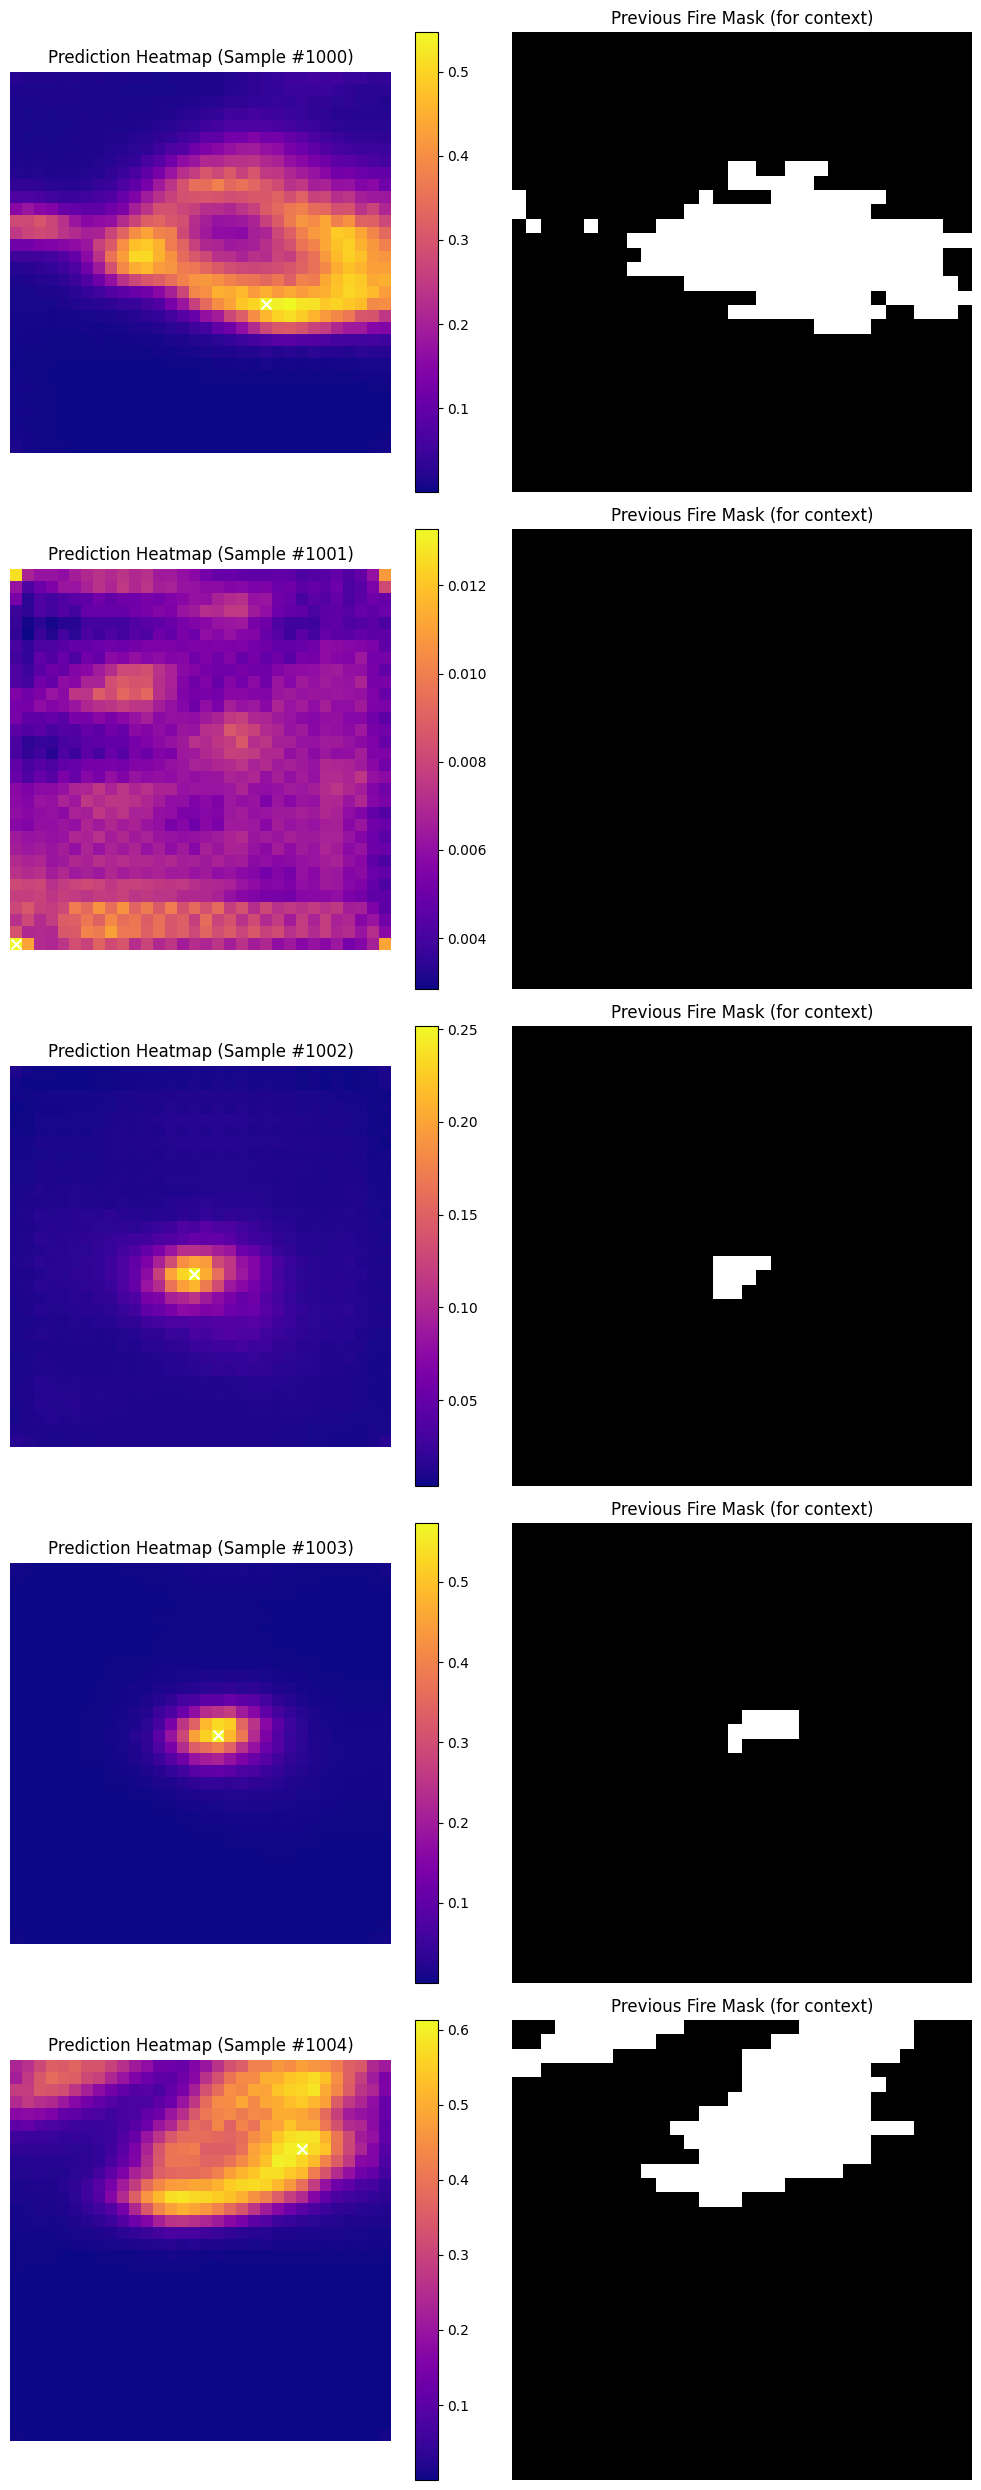

In [38]:
##############################################################################
# Example: For each tile in the batch, find the single pixel with the highest
# predicted-fire probability and print its features.
##############################################################################

# Let's say we want these features (in the order they appear in the input tensor).
FEATURES_TO_PRINT = [
    'elevation', 'th', 'vs', 'tmmn', 'tmmx', 'sph',
    'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask'
]

fig = plt.figure(figsize=(10, 25))
n_rows_to_show = 5  # How many samples to visualize

for i in range(n_rows_to_show):
    sample_idx = i + 1000  # arbitrary offset, pick whichever indices you like

    # --- 1) Plot the entire predicted-heatmap for reference ---
    plt.subplot(n_rows_to_show, 2, 2*i + 1)
    plt.title(f"Prediction Heatmap (Sample #{sample_idx})")
    plt.imshow(pred[sample_idx], cmap='plasma')
    plt.colorbar()
    plt.axis('off')

    # --- 2) Find the pixel with the highest predicted probability in this tile ---
    # pred[sample_idx] has shape [32, 32]
    max_idx = np.unravel_index(np.argmax(pred[sample_idx]), pred[sample_idx].shape)
    row_star, col_star = max_idx
    max_prob = pred[sample_idx, row_star, col_star]

    # --- 3) Plot that “critical” pixel location on top of the heatmap ---
    plt.scatter(col_star, row_star, marker='x', c='white', s=50)

    # --- 4) Retrieve that pixel’s input features from inputs_test ---
    pixel_features = inputs_test[sample_idx, row_star, col_star, :]  # shape (12,)

    # --- 5) Print or display them. Here, we'll just print to console ---
    print(f"\n=== Sample #{sample_idx} ===")
    print(f"Max predicted-fire probability = {max_prob:.4f} at (row={row_star}, col={col_star})")

    # Map each channel to its corresponding feature name
    # WARNING: Make sure the indexing matches how your input channels are ordered
    for f_idx, f_name in enumerate(FEATURES_TO_PRINT):
        print(f"   {f_name:15s} = {pixel_features[f_idx].numpy():.5f}")

    # --- 6) (Optional) Visualize the "previous fire mask" or other references ---
    plt.subplot(n_rows_to_show, 2, 2*i + 2)
    plt.title("Previous Fire Mask (for context)")
    # If PrevFireMask is the last channel, you can do:
    plt.imshow(inputs_test[sample_idx, :, :, -1], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

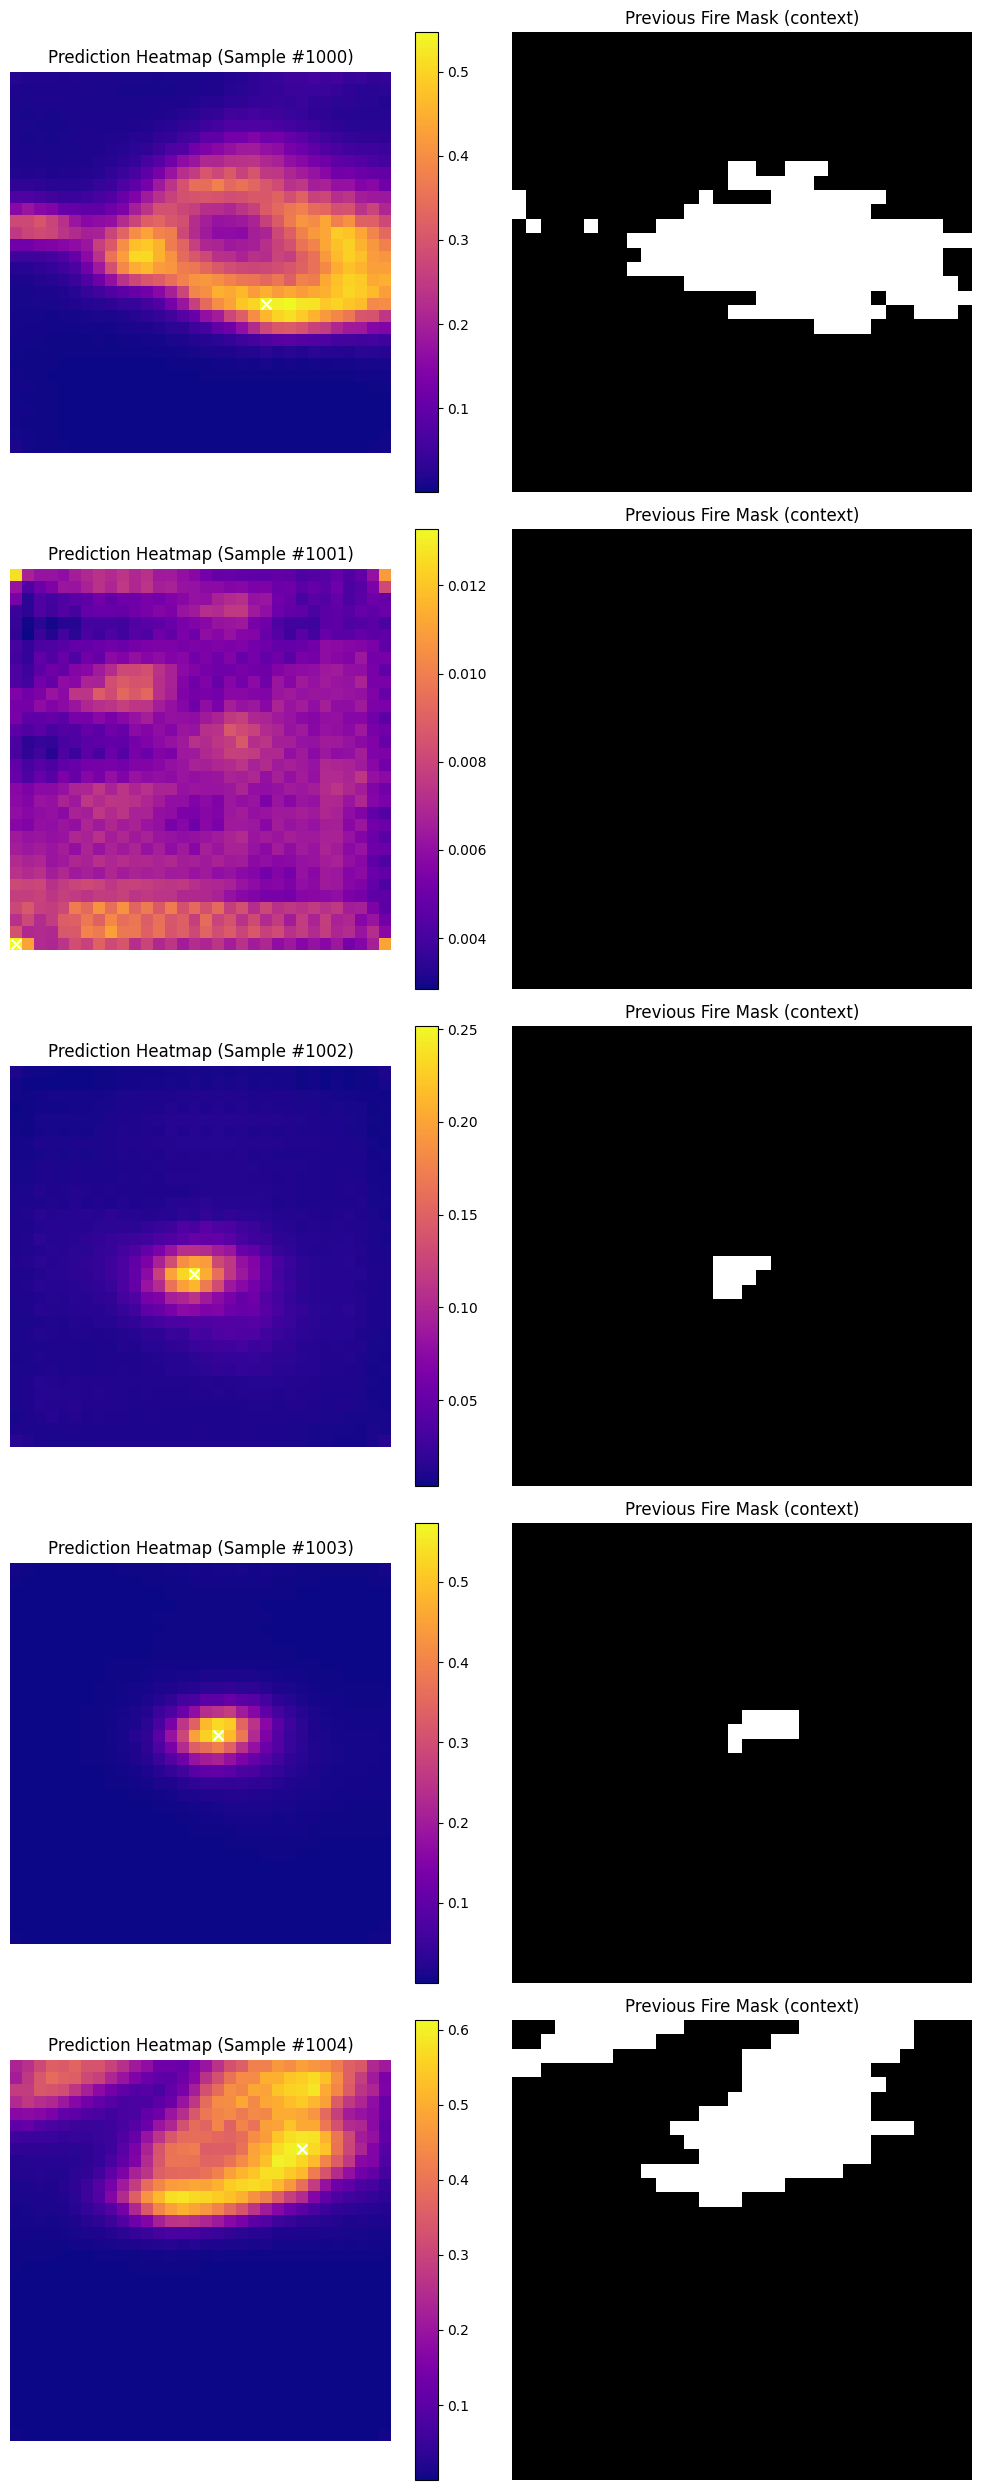

CSV file 'critical_pixel_data.csv' has been saved.


In [40]:
# The same features as before
FEATURES_TO_PRINT = [
    'elevation', 'th', 'vs', 'tmmn', 'tmmx', 'sph',
    'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask'
]

# We'll store a list of dictionaries, one dict per tile we examine
results = []

fig = plt.figure(figsize=(10, 25))
n_rows_to_show = 5  # How many samples to visualize

for i in range(n_rows_to_show):
    sample_idx = i + 1000  # arbitrary offset; pick whichever indices you like

    # --- 1) Plot the predicted heatmap ---
    plt.subplot(n_rows_to_show, 2, 2*i + 1)
    plt.title(f"Prediction Heatmap (Sample #{sample_idx})")
    plt.imshow(pred[sample_idx], cmap='plasma')
    plt.colorbar()
    plt.axis('off')

    # --- 2) Find the pixel with the highest predicted probability in this tile ---
    max_idx = np.unravel_index(np.argmax(pred[sample_idx]), pred[sample_idx].shape)
    row_star, col_star = max_idx
    max_prob = pred[sample_idx, row_star, col_star]

    # (Optional) Mark that pixel on the heatmap.
    plt.scatter(col_star, row_star, marker='x', c='white', s=50)

    # --- 3) Retrieve that pixel’s input features ---
    pixel_features = inputs_test[sample_idx, row_star, col_star, :]  # shape (12,)

    # Create a dict for this tile’s “critical pixel”
    row_dict = {
        'sample_idx': sample_idx,
        'row_star': int(row_star),
        'col_star': int(col_star),
        'max_prob': float(max_prob),  # convert to Python float
    }

    # Add each named feature to the dictionary
    for f_idx, f_name in enumerate(FEATURES_TO_PRINT):
        # Convert tensor to float (if needed)
        val = float(pixel_features[f_idx].numpy())
        row_dict[f_name] = val

    # Append this dictionary to our results list
    results.append(row_dict)

    # --- 4) Optionally visualize the PrevFireMask, etc. ---
    plt.subplot(n_rows_to_show, 2, 2*i + 2)
    plt.title("Previous Fire Mask (context)")
    plt.imshow(inputs_test[sample_idx, :, :, -1], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- 5) Convert to DataFrame and save to CSV ---
df = pd.DataFrame(results)
df.to_csv("critical_pixel_data.csv", index=False)
print("CSV file 'critical_pixel_data.csv' has been saved.")